<a href="https://colab.research.google.com/github/jaketerrito/speedchallenge/blob/autoencoder/Feedforward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/jaketerrito/speedchallenge/raw/master/data/train.mp4
!wget https://github.com/jaketerrito/speedchallenge/raw/master/data/train.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2 as cv

In [3]:
import numpy as np
import time
from os.path import splitext

def denseflow(fname, resize_factor):
    cap = cv.VideoCapture(fname)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
        exit()

    # Get the video dimensions, 3 is the ordinal value of CV_CAP_PROP_FRAME_WIDTH, 4 is CV_CAP_PROP_FRAME_HEIGHT
    # Also resize them because these images are too big
    width = int(cap.get(3) / resize_factor)
    height = int(cap.get(4) / resize_factor)
    shape = (width,height)
    size = int(cap.get(7))
    ret, frame1 = cap.read()
    frame1 = cv.resize(frame1,shape)
    prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    frames = np.zeros((size,hsv.shape[0],hsv.shape[1],3))
    frames[0] = hsv

    fcount = 1
    t = time.time()

    while(1):
        ret, frame2 = cap.read()
        if not ret:
            break
        frame2 = cv.resize(frame2,shape)
        next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
        flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
        frames[fcount] = hsv
        prvs = next
        fcount += 1
    cap.release()

    f, ext = splitext(fname)
    #np.savez(f+'_op', frames)
    return frames

def plainVideo(fname, resize_factor):
    cap = cv.VideoCapture(fname)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
        exit()

    width = int(cap.get(3) / resize_factor)
    height = int(cap.get(4) / resize_factor)
    shape = (width,height)
    size = int(cap.get(7))
    ret, frame1 = cap.read()
    frame1 = cv.resize(frame1,shape)
    
    frames = np.zeros((size, frame1.shape[0], frame1.shape[1],3))
    frames[0] = frame1
    fcount = 1
    while(1):
        ret, frame2 = cap.read()
        if not ret:
            break
        frame2 = cv.resize(frame2,shape)
        frames[fcount] = frame2
        fcount += 1
    cap.release()
    return frames

In [17]:
fname = "data/train.mp4"

try:
    f, ext = splitext(fname)
    with np.load(f + '_op.npz') as data:
        video = data['arr_0']
except:
    print("Could not find preprocessed video, creating it now")
    video = denseflow(fname, 4)

#video = plainVideo(fname, 4)
width = video.shape[2]
height = video.shape[1]
video_size = len(video)

video = video/255

In [18]:
print("Processing speeds.")
with open('data/train.txt') as f:
	speeds = f.readlines()
	speeds = np.array([float(x.strip()) for x in speeds])
	speeds = speeds

Processing speeds.


In [19]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU, PReLU, Conv2DTranspose, Reshape, ZeroPadding2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [205]:
'''
A Generator that produces sets of training features and labels
* video:  A list of video frames
* speeds: A list of corresponding speeds
* batch_size: number of samples to produce for each batch
* sequence_length: number of images that model consider for each prediction
'''
def image_generator(video, batch_size, sequence_length):
    while True:
        sequences = []
        #speed_vals = []
        next_frames = []
        while len(sequences) < batch_size:
            frame_num = random.randrange(sequence_length,len(video)-1)
            sequence = video[frame_num-sequence_length:frame_num]
            next_frame = video[frame_num-1]
            '''
            flip = random.choice([True,False])
            angle = random.uniform(-20,20)
            scale = random.uniform(.8,1.2)
            for i, image in enumerate(sequence):
                # Augmentation
                image = skimage.transform.rescale(image, scale=scale)
                image = skimage.transform.resize(image, output_shape=sequence[i].shape, mode='constant')
                image = skimage.transform.rotate(image, angle=angle)
                # Really need to see the types of values before we add this noise
                image = image + np.random.normal(scale=.5,size=image.shape)
                sequence[i] = image
            '''
            sequences.append(sequence)
            next_frames.append(next_frame)
        yield np.array(sequences), np.array(next_frames)

def speed_generator(video, speeds, batch_size, sequence_length, ae):
    while True:
        sequences = []
        speed_vals = []
        while len(sequences) < batch_size:
            frame_num = random.randrange(sequence_length,len(video))
            sequence = video[frame_num-sequence_length:frame_num]
            '''
            flip = random.choice([True,False])
            angle = random.uniform(-20,20)
            scale = random.uniform(.8,1.2)
            for i, image in enumerate(sequence):
                # Augmentation
                image = skimage.transform.rescale(image, scale=scale)
                image = skimage.transform.resize(image, output_shape=sequence[i].shape, mode='constant')
                image = skimage.transform.rotate(image, angle=angle)
                # Really need to see the types of values before we add this noise
                image = image + np.random.normal(scale=.5,size=image.shape)
                sequence[i] = image
            '''
            #preds = ae.predict(np.array([sequence]))
            #print(preds.shape)
            sequences.append(sequence)
            speed_vals.append(speeds[frame_num-1])
        yield np.array(sequences), np.array(speed_vals)

In [206]:
batch_size = 16
sequence_length = 1
epochs = 10
split = .8
latent_size = 16

train_ae_gen = image_generator(video[:int(video_size*split)], batch_size, sequence_length)
val_ae_gen = image_generator(video[int(video_size*split):], batch_size, sequence_length)

train_re_gen = speed_generator(video[:int(video_size*split)], speeds[:int(video_size*split)], batch_size, sequence_length)
val_re_gen = speed_generator(video[int(video_size*split):], speeds[int(video_size*split):], batch_size, sequence_length)

# Will return a feature and label set.	
# Features are a list of image sequences in the form: (sequence_length, img_height, img_width, dimensions)
def get_encoder():
    inputs = Input((sequence_length,height,width,3))

    # A convolution being applied to each image seperately
    x = Conv3D(32,(1,7,7),strides=(1,3,3),activation=None)(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    #x = Conv3D(32,(1,3,3),strides=(1,2,2),activation=None)(x)
    #x = LeakyReLU(alpha=0.1)(x)
    #x = BatchNormalization()(x)
    x = Conv3D(32,(1,5,5),strides=(1,3,3),activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(32,activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    outputs = Dense(latent_size,activation='tanh')(x)
    return Model(inputs=inputs,outputs=outputs)
  
def get_decoder():
    inputs = Input((latent_size,))
    x = Dense(32,activation=None)(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(12*16*32,activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Reshape((12,16,32))(x)
    x = Conv2DTranspose(32,(5,7),strides=(3,3),activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    #x = BatchNormalization()(x)  
    #x = Conv2DTranspose(32,(3,3),strides=(2,2),activation=None)(x)
    #x = LeakyReLU(alpha=0.1)(x)
    #x = BatchNormalization()(x)
    x = Conv2DTranspose(3,(7,7),strides=(3,3),activation='sigmoid')(x)
    #x = LeakyReLU(alpha=0.1)(x)
    x = ZeroPadding2D((1,0))(x)
    outputs = BatchNormalization()(x)
    return Model(inputs=inputs, outputs=outputs,name='decoder')
# regularizers instead of batch norm?
# try increasing dropout?
# lowering image resolution?
# Try predicting the latent vector of the sequence+nextframe
def get_regression():
    inputs = Input((latent_size,))
    #x = Dropout(.3)(inputs)
    #x = Dense(32,activation=None)(inputs)
   # x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(.3)(x)
    x = Dense(16,activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(.3)(x)
    outputs = Dense(1,activation='linear')(x)
    return Model(inputs=inputs,outputs=outputs,name='regression')

get_encoder().summary()
get_decoder().summary()
#get_regression().summary()

TypeError: speed_generator() missing 1 required positional argument: 'ae'

In [195]:
batch_size = 16
sequence_length = 1
reg_seq = 3
epochs = 20
split = .8
latent_size = 16

train_ae_gen = image_generator(video[:int(video_size*split)], batch_size, sequence_length)
val_ae_gen = image_generator(video[int(video_size*split):], batch_size, sequence_length)

# Will return a feature and label set.	
# Features are a list of image sequences in the form: (sequence_length, img_height, img_width, dimensions)
def get_encoder():
    inputs = Input((sequence_length,height,width,3))

    # A convolution being applied to each image seperately
    x = Conv3D(32,(1,3,3),strides=(1,2,2),activation=None)(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv3D(32,(1,3,3),strides=(1,2,2),activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv3D(32,(1,3,3),strides=(1,2,2),activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv3D(32,(1,3,3),strides=(1,2,2),activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(32,activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    outputs = Dense(latent_size,activation='tanh')(x)
    return Model(inputs=inputs,outputs=outputs)
  
def get_decoder():
    inputs = Input((latent_size,))
    x = Dense(32,activation=None)(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(6*9*32,activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Reshape((6,9,32))(x)
    x = Conv2DTranspose(32,(3,3),strides=(2,2),activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = ZeroPadding2D(((1,0),(0,0)))(x)
    x = BatchNormalization()(x) 
    x = Conv2DTranspose(32,(3,3),strides=(2,2),activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32,(3,3),strides=(2,2),activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(3,(3,3),strides=(2,2),activation='sigmoid')(x)
    #x = LeakyReLU(alpha=0.1)(x)
    x = ZeroPadding2D(((0,1),(0,1)))(x)
    outputs = BatchNormalization()(x)
    return Model(inputs=inputs, outputs=outputs,name='decoder')
# regularizers instead of batch norm?
# try increasing dropout?
# lowering image resolution?
# Try predicting the latent vector of the sequence+nextframe
def get_regression():
    inputs = Input((latent_size*2,))
    #x = Dropout(.3)(inputs)
    x = Dense(32,activation=None)(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(.3)(x)
    x = Dense(16,activation=None)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(.3)(x)
    outputs = Dense(1,activation='linear')(x)
    return Model(inputs=inputs,outputs=outputs,name='regression')

get_encoder().summary()
get_decoder().summary()
#get_regression().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_249 (InputLayer)       (None, 1, 120, 160, 3)    0         
_________________________________________________________________
conv3d_263 (Conv3D)          (None, 1, 59, 79, 32)     896       
_________________________________________________________________
leaky_re_lu_747 (LeakyReLU)  (None, 1, 59, 79, 32)     0         
_________________________________________________________________
batch_normalization_402 (Bat (None, 1, 59, 79, 32)     128       
_________________________________________________________________
conv3d_264 (Conv3D)          (None, 1, 29, 39, 32)     9248      
_________________________________________________________________
leaky_re_lu_748 (LeakyReLU)  (None, 1, 29, 39, 32)     0         
_________________________________________________________________
batch_normalization_403 (Bat (None, 1, 29, 39, 32)     128       
__________

In [207]:
# build the autoencoder
inputs = Input((sequence_length,height,width,3))
latent = get_encoder()(inputs)
regression_output = get_regression()(latent)
dec_output = get_decoder()(latent)
autoencoder = Model(inputs=inputs,outputs=dec_output)
encoder = Model(inputs=inputs, outputs=latent)
regression = Model(inputs=inputs,outputs=regression_output)

# compile with mean absolute error loss on reconstructed image and binary_cross for discriminator
autoencoder.compile(loss='mse',optimizer=Adam())
regression.compile(loss='mse',optimizer=RMSprop())

ValueError: Dimensions must be equal, but are 16 and 32 for 'regression_34/dense_403/MatMul' (op: 'MatMul') with input shapes: [?,16], [32,32].

In [180]:
history = []
reg_history = []
for i in range(epochs):
    print("Real epoch: ", i+1)
    thistory = autoencoder.fit_generator(
        train_ae_gen, 
        steps_per_epoch=int(video_size*split/batch_size), 
        validation_data=val_ae_gen, 
        validation_steps=int(video_size*(1-split)/batch_size),
        epochs=1,
        verbose=True,
        callbacks=[ModelCheckpoint('./data/weights.hdf5',save_best_only=True)]
    )
    print()
    history.append(thistory)
    treg_history = regression.fit_generator(
        train_re_gen, 
        steps_per_epoch=int(video_size*split/batch_size), 
        validation_data=val_re_gen, 
        validation_steps=int(video_size*(1-split)/batch_size),
        epochs=1,
        verbose=True,
        callbacks=[ModelCheckpoint('./data/reg_weights.hdf5',save_best_only=True)]
    )
    reg_history.append(treg_history)
    print()

Real epoch:  1
Epoch 1/1
1020/1020 [==============================] - 55s 54ms/step - loss: 4.3381 - val_loss: 0.6629

Epoch 1/1
1020/1020 [==============================] - 39s 39ms/step - loss: 36.9888 - val_loss: 38.1151

Real epoch:  2
Epoch 1/1
1020/1020 [==============================] - 32s 31ms/step - loss: 0.3544 - val_loss: 0.2760

Epoch 1/1
1020/1020 [==============================] - 21s 21ms/step - loss: 21.7700 - val_loss: 7.5090

Real epoch:  3
Epoch 1/1
1020/1020 [==============================] - 32s 31ms/step - loss: 0.2589 - val_loss: 0.2548

Epoch 1/1
1020/1020 [==============================] - 21s 21ms/step - loss: 17.7437 - val_loss: 26.2928

Real epoch:  4
Epoch 1/1
1020/1020 [==============================] - 32s 31ms/step - loss: 0.2431 - val_loss: 0.2466

Epoch 1/1
1020/1020 [==============================] - 21s 21ms/step - loss: 15.6153 - val_loss: 17.7993

Real epoch:  5
Epoch 1/1
1020/1020 [==============================] - 32s 31ms/step - loss: 0.2339 - 

In [189]:
history = autoencoder.fit_generator(
    train_ae_gen, 
    steps_per_epoch=int(video_size*split/batch_size), 
    validation_data=val_ae_gen, 
    validation_steps=int(video_size*(1-split)/batch_size),
    epochs=epochs,
    verbose=True,
    callbacks=[ModelCheckpoint('./data/weights.hdf5',save_best_only=True)]
)

Epoch 1/20
1020/1020 [==============================] - 56s 55ms/step - loss: 4.4020 - val_loss: 0.6683
Epoch 2/20
1020/1020 [==============================] - 32s 32ms/step - loss: 0.3448 - val_loss: 0.2737
Epoch 3/20
1020/1020 [==============================] - 32s 32ms/step - loss: 0.2485 - val_loss: 0.2567
Epoch 4/20
1020/1020 [==============================] - 32s 32ms/step - loss: 0.2354 - val_loss: 0.2478
Epoch 5/20
1020/1020 [==============================] - 33s 33ms/step - loss: 0.2274 - val_loss: 0.2385
Epoch 6/20
1020/1020 [==============================] - 35s 34ms/step - loss: 0.2237 - val_loss: 0.2358
Epoch 7/20
1020/1020 [==============================] - 36s 35ms/step - loss: 0.2218 - val_loss: 0.2351
Epoch 8/20
1020/1020 [==============================] - 36s 35ms/step - loss: 0.2190 - val_loss: 0.2375
Epoch 9/20
1020/1020 [==============================] - 36s 35ms/step - loss: 0.2181 - val_loss: 0.2330
Epoch 10/20
1020/1020 [==============================] - 35s 34m

In [204]:
train_re_gen = speed_generator(video[:int(video_size*split)], speeds[:int(video_size*split)], batch_size, reg_seq, encoder)
#val_re_gen = speed_generator(video[int(video_size*split):], speeds[int(video_size*split):], batch_size, sequence_length)
train_re_gen.__next__()

ValueError: Error when checking input: expected input_251 to have shape (1, 120, 160, 3) but got array with shape (3, 120, 160, 3)

In [190]:
reg_history = regression.fit_generator(
    train_re_gen, 
    steps_per_epoch=int(video_size*split/batch_size), 
    validation_data=val_re_gen, 
    validation_steps=int(video_size*(1-split)/batch_size),
    epochs=epochs,
    verbose=True,
    callbacks=[ModelCheckpoint('./data/reg_weights.hdf5',save_best_only=True)]
)

Epoch 1/20
1020/1020 [==============================] - 42s 41ms/step - loss: 37.0307 - val_loss: 7.4740
Epoch 2/20
1020/1020 [==============================] - 22s 21ms/step - loss: 18.2708 - val_loss: 13.2526
Epoch 3/20
1020/1020 [==============================] - 22s 21ms/step - loss: 15.5410 - val_loss: 9.2113
Epoch 4/20
1020/1020 [==============================] - 22s 22ms/step - loss: 13.5366 - val_loss: 11.8100
Epoch 5/20
1020/1020 [==============================] - 22s 21ms/step - loss: 11.9968 - val_loss: 14.4941
Epoch 6/20
1020/1020 [==============================] - 21s 21ms/step - loss: 10.9500 - val_loss: 26.1381
Epoch 7/20
1020/1020 [==============================] - 22s 21ms/step - loss: 10.4889 - val_loss: 7.2338
Epoch 8/20
1020/1020 [==============================] - 22s 21ms/step - loss: 9.5232 - val_loss: 18.8696
Epoch 9/20
1020/1020 [==============================] - 22s 22ms/step - loss: 8.8480 - val_loss: 13.7748
Epoch 10/20
1020/1020 [============================

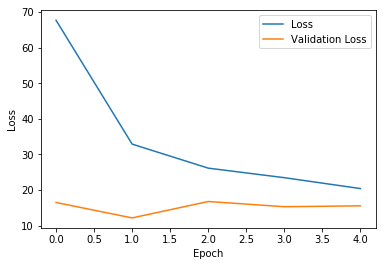

<Figure size 432x288 with 0 Axes>

In [74]:
# Plot the training loss against the validation loss
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.savefig(fname='./data/lossplot')
plt.show()

plt.clf()

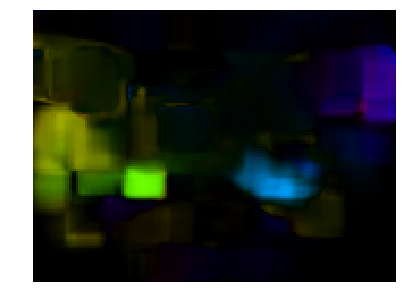

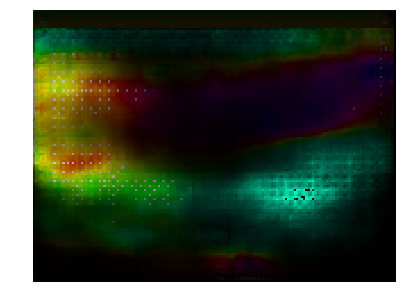

In [185]:
def denseflow_as_image(x):
  x = x.astype(np.uint8)
  x = cv.cvtColor(x,cv.COLOR_HSV2BGR)
  return x

def show_grid_of_images(x):
  plt.figure(figsize=(50,5))
  for i in range(len(x)):
    plt.subplot(1,len(x),i+1)
    plt.imshow(denseflow_as_image(x[i]))
    plt.axis('off')

  plt.show()
  
#import imageio
'''
def display_gif(sequence):
  sequence = map(denseflow_as_image,sequence)
  imageio.mimsave('test.gif', sequence)

  from IPython.display import Image
  with open('test.gif','rb') as file:
      display(Image(file.read()))'''

#### MAKE THIS PRINT OUT THE EXPECTED IMG FOR NEXT FRAME
ims, _ = next(train_ae_gen)
preds = autoencoder.predict(ims)
show_grid_of_images(ims[1]*255)
show_grid_of_images([preds[1]*255])